# Post-Hoc Analysis for the ReNeuIR Shared Task

This notebook contains an inspiration for potential post-hoc analysis of the [2024 ReNeuIR shared task](https://reneuir.org/shared_task.html).

**Attention:** The shared task is still ongoing, therefore, new systems might be submitted, additional datasets might be added, etc. Please do not hesitate to contact us to incorporate your ideas for potential additional evaluation scenarios and/or systems that we should include.

### Step 1: Prepare Imports

In [ ]:
# this version of tira already includes the zenodo backups for the reneuir-datasets
!pip3 install -U 'tira>=0.0.136'

In [1]:
from tira.rest_api_client import Client
from tira.third_party_integrations import ir_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
from ir_measures import *
from ir_measures import calc_aggregate

# do not truncate pandas columns and rows
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

tira = Client()

The file `systems.json` contains an overview of all systems, heach entry looks like:

```
"reneuir-2024/reneuir-baselines/plaid-x-retrieval": {
    "previous-stage": ["reneuir-2024/reneuir-baselines/plaid-x-index"],
    "runs": {
        "dl-top-1000-docs-20240701-training": "2024-07-06-05-43-12"
    },
    "class": "bi-encoder-retriever"
}
```

Where the `previous-stage` field indicates which previous stages are the inputs to an system (e.g., to execute the `plaid-x-retrieval` system, you need an index produced by `plaid-x-index`), `runs` contain the executions of the system (dataset-id points to run-id), and the `class` indicates to which class of retrieval systems a system belongs to.

In [4]:
!head -9 systems.json

{
    "reneuir-2024/reneuir-baselines/plaid-x-index": {
        "previous-stage": [],
        "runs": {
            "dl-top-1000-docs-20240701-training": "2024-07-05-14-44-15",
            "dl-top-100-docs-20240701-training": "2024-07-05-14-17-33",
            "dl-top-10-docs-20240701-training": "2024-07-05-14-15-16"
        }    
    },


### High-Level Overview of the Systems

In [5]:
# The main dataset id for effectiveness/efficiency evaluation
dataset_id = 'reneuir-2024/dl-top-1000-docs-20240701-training'

qrels = list(ir_datasets.load(dataset_id).qrels_iter())
aggregated_telemetry = json.load(open('aggregated-telemetry.json'))

APPROACHES = [
    'reneuir-2024/reneuir-baselines/plaid-x-retrieval', 'reneuir-2024/fschlatt/plaid-x-rank-zephyr', 'reneuir-2024/fschlatt/list-in-t5-re-rank-plaid-x',
    'reneuir-2024/fschlatt/monoelectra-large', 'reneuir-2024/fschlatt/monoelectra-base', 'reneuir-2024/fschlatt/rank-zephyr',
    'reneuir-2024/fschlatt/castorini-list-in-t5-150', 'reneuir-2024/fschlatt/sparse-cross-encoder-4-512', 'reneuir-2024/reneuir-baselines/llm-rankers-flan-t5-xl-top-100',
    'reneuir-2024/reneuir-baselines/llm-rankers-flan-t5-large-top-100', 'reneuir-2024/reneuir-baselines/llm-rankers-vicuna-13b-v1.5-top-100', 'reneuir-2024/reneuir-baselines/llm-rankers-flan-t5-xxl-top-100',
    'reneuir-2024/reneuir-baselines/llm-rankers-llama-2-7b-chat-top-100', 'reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-flan-t5-xxl', 'reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-flan-t5-xl',
    'reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-vicuna-13b-v1.5', 'reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-flan-t5-large', 'reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-llama-2-7b-chat',
    'reneuir-2024/reneuir-baselines/anserini-bm25', 'reneuir-2024/reneuir-baselines/anserini-qld', 'reneuir-2024/reneuir-baselines/anserini-inl2',
    'reneuir-2024/reneuir-baselines/anserini-spl', 'reneuir-2024/reneuir-baselines/anserini-f2log', 'reneuir-2024/reneuir-baselines/anserini-f2exp',
    'reneuir-2024/tinyfsu/tiny-fsu-bert', 'reneuir-2024/tinyfsu/cross-encoder-ms-marco-TinyBERT-L-2', 'reneuir-2024/tinyfsu/tiny-bert-ranker-bm25',
    'reneuir-2024/tinyfsu/tiny-bert-ranker-l2-bm25', 'reneuir-2024/tinyfsu/tiny-bert-ranker-distillation', 'reneuir-2024/tinyfsu/tiny-bert-ranker-l-2-distillation',
    'reneuir-2024/naverlabseurope/Splade (re-ranker)', 'reneuir-2024/tu-dresden-03/bm25-flan-ul2-chain-of-thoughts-expansion-10', 'reneuir-2024/tu-dresden-03/bm25-flan-ul2-similar-queries-few-shot-5',
    'reneuir-2024/tu-dresden-03/bm25-flan-ul2-similar-queries-zero-shot-5', 'reneuir-2024/tu-dresden-03/bm25-llama2-chain-of-thoughts-10', 'reneuir-2024/tu-dresden-03/bm25-llama2-similar-queries-few-shot-5',
    'reneuir-2024/tu-dresden-03/bm25-llama2-similar-queries-zero-shot-5', 'reneuir-2024/tira-ir-starter/MonoT5 Base (tira-ir-starter-gygaggle)', 'reneuir-2024/tira-ir-starter/ColBERT Re-Rank (tira-ir-starter-pyterrier)',
    'reneuir-2024/tira-ir-starter/TASB msmarco-distilbert-base-cos (tira-ir-starter-beir)', 'reneuir-2024/tira-ir-starter/ANCE Base Dot (tira-ir-starter-beir)', 'reneuir-2024/tira-ir-starter/MonoT5 3b (tira-ir-starter-gygaggle)',
    'reneuir-2024/tira-ir-starter/MonoBERT Large (tira-ir-starter-gygaggle)', 'reneuir-2024/tira-ir-starter/MonoBERT Small (tira-ir-starter-gygaggle)', 'reneuir-2024/tira-ir-starter/SBERT multi-qa-mpnet-base-dot-v1 (tira-ir-starter-beir)',
    'reneuir-2024/tira-ir-starter/SBERT msmarco-distilbert-dot-v5 (tira-ir-starter-beir)', 'reneuir-2024/ows/pyterrier-anceretrieval', 'reneuir-2024/reneuir-baselines/mono-duo-t5-3b-top-50',
    'reneuir-2024/reneuir-baselines/mono-duo-t5-3b-top-25', 'reneuir-2024/reneuir-baselines/pyterrier-bm25', 'reneuir-2024/reneuir-baselines/pyterrier-pl2',
    'reneuir-2024/reneuir-baselines/pyterrier-dirichletlm', 'reneuir-2024/reneuir-baselines/pyterrier-dlh', 'reneuir-2024/reneuir-baselines/pyterrier-dph',
    'reneuir-2024/reneuir-baselines/pyterrier-ln-exp-b2', 'reneuir-2024/reneuir-baselines/fusion-monot5', 'reneuir-2024/reneuir-baselines/plaid-mono-t5',
    'reneuir-2024/fschlatt/set-encoder-base', 'reneuir-2024/fschlatt/set-encoder-large', 'reneuir-2024/fschlatt/fusion-t5-rank-zephyr',
    'reneuir-2024/reneuir-baselines/rankllama'
]

In [19]:
systems_to_class = {k: v.get('class') for k,v in json.load(open('systems.json', 'r')).items()}

df_systems = pd.DataFrame([{'system': k, 'class': v} for k, v in systems_to_class.items()])
df_systems['class'].value_counts()

class
cross-encoder-ranker        27
llm-cross-encoder-ranker    14
sparse-retriever            12
llm-expansions               6
llm-expansion-retriever      6
bi-encoder-retriever         2
Name: count, dtype: int64

# Evaluations

In [20]:
df_eval = []

for i in tqdm(APPROACHES):
    run = tira.pd.from_retriever_submission(i, dataset_id, for_ir_measures=True)

    tmp = calc_aggregate([nDCG@10, nDCG(judged_only=True)@10], qrels, run)
    tmp = {'approach': i, 'class': systems_to_class[i], 'nDCG@10': tmp[nDCG@10], 'nDCG@10 (condensed)': tmp[nDCG(judged_only=True)@10]}
    tmp.update(aggregated_telemetry[i])
    df_eval += [tmp]

df_eval = pd.DataFrame(df_eval)


  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 61/61 [00:11<00:00,  5.38it/s]


In [21]:
df_eval.sort_values(by='nDCG@10', ascending=False).reset_index()[['approach', 'nDCG@10',  'nDCG@10 (condensed)', 'Elapsed Time', 'GPU Memory (Max)', 'GPU Utilization (Max)', ]]

,approach,nDCG@10,nDCG@10 (condensed),Elapsed Time,GPU Memory (Max),GPU Utilization (Max)
0,reneuir-2024/fschlatt/plaid-x-rank-zephyr,0.786125,0.805719,4272.0,23214,100
1,reneuir-2024/fschlatt/fusion-t5-rank-zephyr,0.782695,0.804908,10285.0,26004,100
2,reneuir-2024/reneuir-baselines/mono-duo-t5-3b-top-25,0.744482,0.747402,5603.0,20504,100
3,reneuir-2024/reneuir-baselines/fusion-monot5,0.744038,0.760422,7734.0,20504,100
4,reneuir-2024/reneuir-baselines/plaid-mono-t5,0.743741,0.761778,4895.0,19774,100
5,reneuir-2024/fschlatt/list-in-t5-re-rank-plaid-x,0.743435,0.768909,2100.0,7426,100
6,reneuir-2024/fschlatt/monoelectra-large,0.741231,0.759798,614.0,20612,100
7,reneuir-2024/tira-ir-starter/MonoT5 3b (tira-ir-starter-gygaggle),0.740981,0.745614,2828.0,20504,100
8,reneuir-2024/reneuir-baselines/rankllama,0.734989,0.738701,1683.0,35148,99
9,reneuir-2024/fschlatt/rank-zephyr,0.727169,0.735598,2578.0,22902,100


In [22]:
df_eval.sort_values(by='Elapsed Time', ascending=False).reset_index()[['approach', 'nDCG@10', 'Elapsed Time', 'GPU Memory (Max)', 'GPU Utilization (Max)', ]]

,approach,nDCG@10,Elapsed Time,GPU Memory (Max),GPU Utilization (Max)
0,reneuir-2024/reneuir-baselines/mono-duo-t5-3b-top-50,0.715863,13734.0,20504,100
1,reneuir-2024/fschlatt/fusion-t5-rank-zephyr,0.782695,10285.0,26004,100
2,reneuir-2024/reneuir-baselines/fusion-monot5,0.744038,7734.0,20504,100
3,reneuir-2024/reneuir-baselines/mono-duo-t5-3b-top-25,0.744482,5603.0,20504,100
4,reneuir-2024/reneuir-baselines/plaid-mono-t5,0.743741,4895.0,19774,100
5,reneuir-2024/fschlatt/plaid-x-rank-zephyr,0.786125,4272.0,23214,100
6,reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-flan-t5-xxl,0.706633,3034.0,27250,100
7,reneuir-2024/tira-ir-starter/MonoT5 3b (tira-ir-starter-gygaggle),0.740981,2828.0,20504,100
8,reneuir-2024/fschlatt/rank-zephyr,0.727169,2578.0,22902,100
9,reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-flan-t5-xl,0.684264,2427.0,8530,100


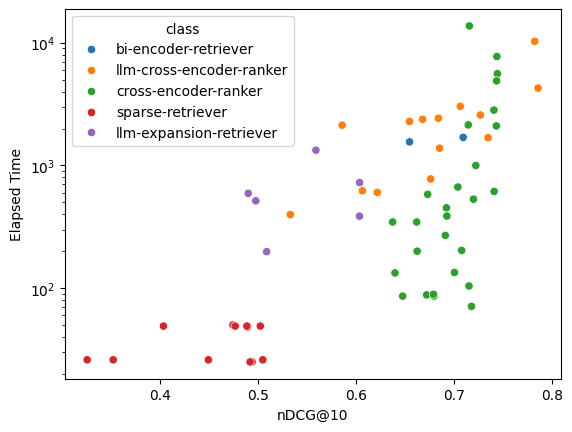

In [26]:
p = sns.scatterplot(data=df_eval, y='Elapsed Time', x='nDCG@10', hue='class')
p.set_yscale("log")

<Axes: xlabel='nDCG@10', ylabel='GPU Memory (Max)'>

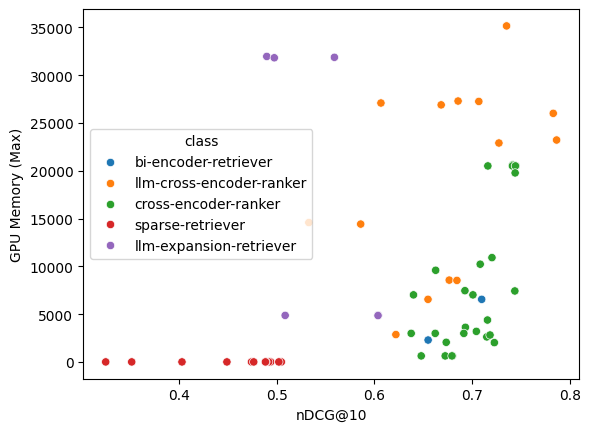

In [27]:
sns.scatterplot(data=df_eval, y='GPU Memory (Max)', x='nDCG@10', hue='class')

# Pseudo TREC Run for Comparison

We concatenate the best run from TREC DL 19 with the best run from TREC DL 20 to contrast the systems.

In [21]:
# runs obtained by concatenating the best run from DL 19 with the best run of DL 20 and the run of the second-best group of DL 19 with the run of the second best group of DL 20

df_eval = []
for i in ['dl-run-pash-r3-concat-idst-bert-p1.run.gz', 'dl-run-p-exp-rm3-bert-concat-p_d2q_bm25_duo.run.gz']:
    run = pd.read_csv(i, sep="\s+", names=["query_id", "q0", "doc_id", "rank", "score", "system"], dtype={'query_id': str, 'doc_id': str})
    df_eval += [{'system': i, 'nDCG@10': calc_aggregate([nDCG@10], qrels, run)[nDCG@10]}]

df_eval = pd.DataFrame(df_eval)
df_eval

,system,nDCG@10
0,dl-run-pash-r3-concat-idst-bert-p1.run.gz,0.787652
1,dl-run-p-exp-rm3-bert-concat-p_d2q_bm25_duo.run.gz,0.767081


In [7]:
from glob import glob
dl_19_runs = glob('runs-trec/dl-19-official-input*')
dl_20_runs = glob('runs-trec/dl-20-official-input*')

In [17]:
df_eval = []

for i in tqdm(dl_19_runs):
    run = pd.read_csv(i, sep="\s+", names=["query_id", "q0", "doc_id", "rank", "score", "system"], dtype={'query_id': str, 'doc_id': str})
    
    df_eval += [{'system': i, 'nDCG@10': calc_aggregate([nDCG@10], qrels, run)[nDCG@10]}]

df_eval = pd.DataFrame(df_eval)
df_eval.sort_values(by='nDCG@10', ascending=False).reset_index()[['system', 'nDCG@10']]

100%|██████████| 37/37 [00:13<00:00,  2.69it/s]


,system,nDCG@10
0,runs-trec/dl-19-official-input.idst_bert_p1.gz,0.340103
1,runs-trec/dl-19-official-input.idst_bert_p2.gz,0.339481
2,runs-trec/dl-19-official-input.idst_bert_p3.gz,0.337828
3,runs-trec/dl-19-official-input.p_exp_rm3_bert.gz,0.330185
4,runs-trec/dl-19-official-input.p_bert.gz,0.328082
5,runs-trec/dl-19-official-input.idst_bert_pr2.gz,0.327909
6,runs-trec/dl-19-official-input.idst_bert_pr1.gz,0.327850
7,runs-trec/dl-19-official-input.p_exp_bert.gz,0.326236
8,runs-trec/dl-19-official-input.test1.gz,0.325028
9,runs-trec/dl-19-official-input.TUA1-1.gz,0.325028


In [18]:
df_eval = []

for i in tqdm(dl_20_runs):
    run = pd.read_csv(i, sep="\s+", names=["query_id", "q0", "doc_id", "rank", "score", "system"], dtype={'query_id': str, 'doc_id': str})
    
    df_eval += [{'system': i, 'nDCG@10': calc_aggregate([nDCG@10], qrels, run)[nDCG@10]}]

df_eval = pd.DataFrame(df_eval)
df_eval.sort_values(by='nDCG@10', ascending=False).reset_index()[['system', 'nDCG@10']]

100%|██████████| 59/59 [00:27<00:00,  2.17it/s]


,system,nDCG@10
0,runs-trec/dl-20-official-input.pash_r3.gz,0.447549
1,runs-trec/dl-20-official-input.pash_r2.gz,0.446441
2,runs-trec/dl-20-official-input.pash_f3.gz,0.446133
3,runs-trec/dl-20-official-input.pash_f1.gz,0.443388
4,runs-trec/dl-20-official-input.pash_f2.gz,0.442562
5,runs-trec/dl-20-official-input.p_d2q_bm25_duo.gz,0.436895
6,runs-trec/dl-20-official-input.p_d2q_rm3_duo.gz,0.436047
7,runs-trec/dl-20-official-input.p_bm25rm3_duo.gz,0.422685
8,runs-trec/dl-20-official-input.CoRT-electra.gz,0.421731
9,runs-trec/dl-20-official-input.RMIT-Bart.gz,0.420016
